In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [2]:
from elitho.mask_pattern import LinePattern
from elitho import const
from elitho import fourier

mask = LinePattern(cd=56, gap=80, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

/home/moshida/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
type(mask)

numpy.ndarray

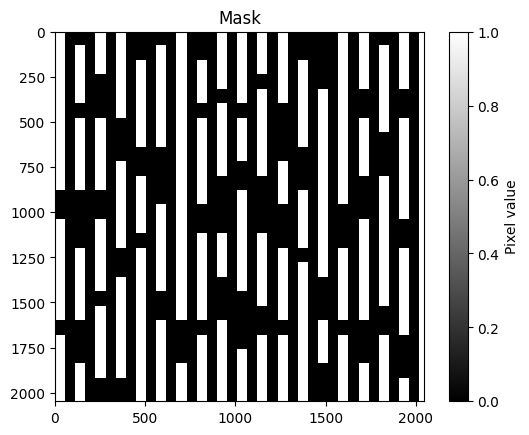

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [27]:
# %%timeit -n 10
# cpu ver
ampta = 0.95 + 0.0j
ampvc = 1.0 + 0.0j
famp = fourier.mask(mask, ampta, ampvc)

In [ ]:
from elitho import descriptors, diffraction_order
dod = descriptors.DiffractionOrderDescriptor(6.0, diffraction_order.rounded_diamond)

In [33]:
# %%timeit -n 10
# cpu ver
_, _, _, _ = fourier.coefficients(mask, const.absorption_amplitudes, dod)

/tmp/ipykernel_3997427/1433951773.py:2: RuntimeWarning: divide by zero encountered in log
  famp = np.maximum(np.log(np.abs(famp)) + 10, 0)


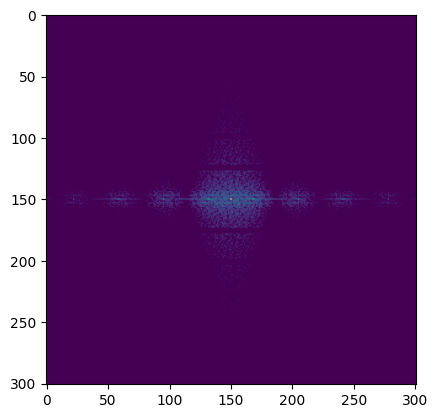

In [29]:
import numpy as np
famp = np.maximum(np.log(np.abs(famp)) + 10, 0)
plt.imshow(famp)
plt.show()

In [16]:
def test_np_ver(pattern_mask: np.ndarray, ampta: complex, ampvc: complex): 
    meshX = const.FDIVX // const.NDIVX
    meshY = const.FDIVY // const.NDIVY

    pattern = np.where(
        np.kron(pattern_mask, np.ones((meshX, meshY))), ampta, ampvc
    ).astype(
        np.complex128
    )  # shape: (FDIVX, FDIVY)

    famp_full = np.fft.fftshift(np.fft.fft2(pattern)) / (const.FDIVX * const.FDIVY)

    # === 3. 周波数中心付近の領域を切り出す ===
    cx = const.FDIVX // 2
    cy = const.FDIVY // 2
    half_L = const.Lrange2 // 2
    half_M = const.Mrange2 // 2

    famp = famp_full[
        cx - half_L : cx + half_L + (const.Lrange2 % 2),
        cy - half_M : cy + half_M + (const.Mrange2 % 2)
    ]
    
    return famp

In [17]:
own_famp = test_np_ver(mask, ampta, ampvc)
own_rfamp = np.maximum(np.log(np.abs(own_famp)) + 10, 0)

/tmp/ipykernel_3997427/3198047890.py:2: RuntimeWarning: divide by zero encountered in log
  own_rfamp = np.maximum(np.log(np.abs(own_famp)) + 10, 0)


In [18]:
own_rfamp.shape

(301, 301)

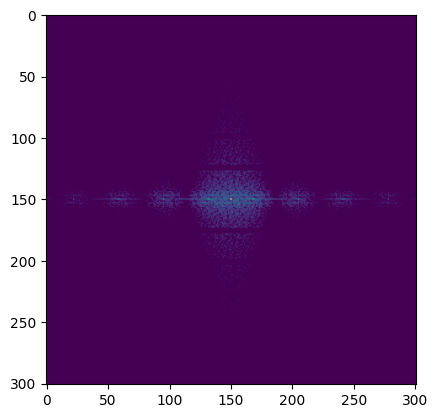

In [19]:
plt.imshow(own_rfamp)
plt.show()

In [30]:
np.allclose(famp, own_rfamp, atol=1e-6, rtol=1e-4)

True